In [1]:
from importlib import reload
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import scipy as sc
import torch
import copy

import assay
import designer
import dre
import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
# throughout, d will refer to the dimension of each of u, v
# x is 2d-dimensional

def get_mi(d):
    # from MI = S1 + S2 - SX
    det_Sigma = np.power(0.36, d)
    return 0.5 * np.log(1 / det_Sigma)

def get_cov(d):
    cov = np.eye(2 * d)
    for i in range(0, 2 * d, 2):
        cov[i, i + 1] = 0.8
        cov[i + 1, i] = 0.8
    return cov

def get_data(n, d):
    zm = np.zeros([2 * d])
    X_nx2d = sc.stats.multivariate_normal.rvs(mean=zm, cov=get_cov(d), size=n)
    UV_nx2d = sc.stats.multivariate_normal.rvs(mean=zm, cov=np.eye(2 * d), size=n)
    return X_nx2d, UV_nx2d

def get_ldre(X_nx2d):
    d = int(X_nx2d.shape[1] / 2)
    zm = np.zeros([2 * d])
    logn_n = sc.stats.multivariate_normal.logpdf(X_nx2d, mean=zm, cov=get_cov(d))
    logd_n = sc.stats.multivariate_normal.logpdf(X_nx2d, mean=zm, cov=np.eye(2 * d))
    return logn_n - logd_n


class Quadratic(torch.nn.Module):
    def __init__(self, dim, linear_component: bool = False):
        super().__init__()
        self.dim = dim
        self.vals = torch.nn.Parameter(torch.randn(int(dim * (dim + 1) / 2 - dim)))
        self.diag = torch.nn.Parameter(torch.rand((dim)))
        self.linear = torch.nn.Parameter(torch.rand((dim, 1)))
        self.linear_component = linear_component
        self.b = torch.nn.Parameter(torch.randn(()))
        self.di = range(dim)
        self.i, self.j = i, j = np.triu_indices(self.dim, k=1)  # don't include diag

    def forward(self, x):
        # x is nxd
        W = torch.empty(self.dim, self.dim)  # template
        
        W[self.i, self.j] = self.vals
        W.T[self.i, self.j] = self.vals
        W[self.di, self.di] = self.diag
        
        t1_nxd = torch.matmul(x, W)
        t2_nxd = t1_nxd * x
        t3_nx1 = t2_nxd.sum(axis=1, keepdim=True)
        if self.linear_component:
            return t3_nx1 + self.b + torch.matmul(x, self.linear)
        return t3_nx1 + self.b
        

class LogDensityRatioEstimator(torch.nn.Module):
    def __init__(self, d, lr, n_steps, device=None, 
                 real_d: bool = False, linear_component: bool = False):
        super().__init__()

        self.classifier = torch.nn.Sequential(
            Quadratic(d if real_d else 2 * d, linear_component=linear_component)
        ).to(device=device)
        self.n_steps = n_steps
        self.lr = lr
        self.n_steps = n_steps
        self.device = device
        
    def forward(self, x):
        return self.classifier(x).squeeze(-1).numpy()
    
    def estimate_mi(self, X_nx2d):
        ldr_n = self(torch.Tensor(X_nx2d, device=self.device))
        return np.mean(ldr_n), ldr_n
    
    def fit(self, X_nx2d, UV_nx2d, val_frac: float = 0.1):
        tX_nx2d = torch.Tensor(X_nx2d, device=self.device)
        tUV_nx2d = torch.Tensor(UV_nx2d, device=self.device)
        n = X_nx2d.shape[0]
        
        zX = torch.ones((n), 1, device=self.device) 
        zUV = torch.zeros((n), 1, device=self.device)
        x_all = torch.cat([tX_nx2d, tUV_nx2d])
        z_all = torch.cat([zX, zUV])

        if val_frac:
            n_val = int(val_frac * x_all.shape[0])
            rand_perm = np.random.permutation(x_all.shape[0])
            xval_x2d = x_all[rand_perm[:n_val]]
            zval_x1 = z_all[rand_perm[:n_val]]
            xtr_nx2d = x_all[rand_perm[n_val:]]
            ztr_nx1 = z_all[rand_perm[n_val:]]
        else:
            n_val = 0
            xtr_nx2d = x_all
            ztr_nx1 = z_all
            xval_x2d = None
            zval_x1 = None

        loss_fn = torch.nn.BCEWithLogitsLoss()
        self.classifier.requires_grad_(True)
        optim = torch.optim.Adam(
            self.classifier.parameters(), lr=self.lr
        )

        best_loss = float('inf')
        losses = []
        val_loss = 0

        for _ in tqdm(range(self.n_steps)):
            if n_val:
                with torch.no_grad():
                    val_logits = self.classifier(xval_x2d)
                    val_loss = loss_fn(val_logits, zval_x1)
                    v_loss = bcewithlogitsloss(
                        val_logits.detach().numpy(), zval_x1.detach().numpy())

            self.classifier.zero_grad()
            train_logits = self.classifier(xtr_nx2d)
            train_loss = loss_fn(train_logits, ztr_nx1)
            tr_loss = bcewithlogitsloss(
                train_logits.detach().numpy(), ztr_nx1.detach().numpy())

            if n_val and val_loss < best_loss:
                best_loss = val_loss.item()
                best_weights = copy.deepcopy(self.classifier.state_dict())
                ckpt_train_loss = train_loss.item()
            elif train_loss < best_loss:
                best_loss = train_loss.item()
                best_weights = copy.deepcopy(self.classifier.state_dict())
                ckpt_train_loss = train_loss.item()

            train_loss.backward()
            optim.step()
            params = self.classifier.state_dict()
            params['0.diag'].clamp(min=0)  # enforce positive diagonals
            losses.append([
                ckpt_train_loss,
                val_loss.item() if n_val else val_loss,
                tr_loss, v_loss
            ])

        self.classifier.load_state_dict(best_weights)
        self.classifier.requires_grad_(False)
        df = pd.DataFrame(
            losses, 
            columns=["train_loss", "val_loss", 'my_train_loss', 'my_val_loss'])
        return df
    
def sigm(x):
    t =  1 / (1 + np.exp(-x))
    return np.clip(t, 1e-6, 1 - 1e-6)

def bcewithlogitsloss(ldr_n, z_n):
    t_n = sigm(ldr_n)
    return -np.mean(z_n * np.log(t_n) + (1 - z_n) * np.log(1 - t_n))

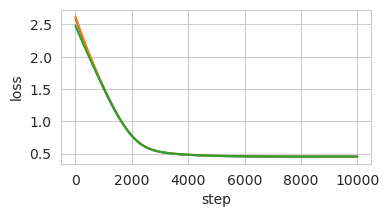

In [5]:
n = 10000
d = 2
lr = 5e-4
n_steps = 10000

ldre = LogDensityRatioEstimator(d, lr, n_steps)
X_nx2d, UV_nx2d = get_data(n, d)
df = ldre.fit(X_nx2d, UV_nx2d)

plt.figure(figsize=(4, 2))
plt.plot(df['train_loss']);
plt.plot(df['val_loss']);
plt.plot(df['my_val_loss']);

plt.xlabel('step');
plt.ylabel('loss');

1.0216512475319814 0.99863875


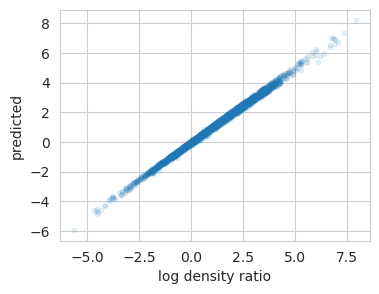

In [8]:
X_nx2d, UV_nx2d = get_data(n, d)

ldrepred, ldrepred_n = estimate_mi(X_nx2d, ldre)
ldretrue = get_mi(d)
ldretrue_n = get_ldre(X_nx2d)
print(ldretrue, ldrepred)

plt.figure(figsize=(4, 3))
plt.scatter(ldretrue_n, ldrepred_n, alpha=0.1, s=10);
plt.xlabel('log density ratio');
plt.ylabel('predicted');

In [24]:
n = 100000
n_steps = 10000
lr = 5e-4
ds = np.arange(2, 20, 6)
estmi_d = np.empty([ds.size])
for i, d in enumerate(ds):
    ldre = LogDensityRatioEstimator(d, lr, n_steps)
    X_nx2d, UV_nx2d = get_data(n, d)
    df = ldre.fit(X_nx2d, UV_nx2d)
    
    X_nx2d, UV_nx2d = get_data(n, d)
    estmi, _ = estimate_mi(X_nx2d, ldre)
    estmi_d[i] = estmi
    print(d, estmi)

2 0.9909686


/tmp/ipykernel_1709/1741544610.py:145: RuntimeWarning: overflow encountered in exp
  t =  1 / (1 + np.exp(-x))


8 3.7470813
14 7.902348


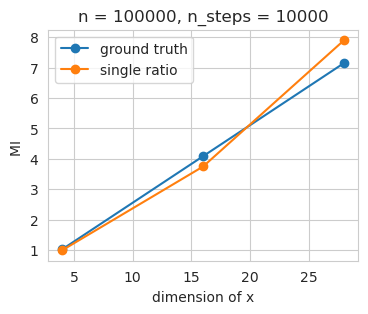

In [28]:
mi_d = np.array([get_mi(d) for d in ds])
plt.figure(figsize=(4, 3))
plt.plot(2 * ds, mi_d, '-o', label='ground truth');  # # d is the dimension of each of u, v
plt.plot(2 * ds, estmi_d, '-o', label='single ratio');

plt.xlabel('dimension of x');
plt.ylabel('MI ');
plt.legend();
plt.title('n = {}, n_steps = {}'.format(n, n_steps));


# telescoping!

In [3]:
def get_alphas(m, p=1):
    # a_m1 = np.sqrt(np.arange(0, m + 1) / m)  # TODO: convex combos of variances
    a_m1 = np.power(np.arange(0, m + 1) / m, p) 
    return a_m1

def get_waymark_samples(X0_nxd, Xm_nxd, a_m1):
    m = a_m1.size - 1
    n, d = Xm_nxd.shape
    
    X_m1xnxd = np.zeros([m + 1, n, d])
    X_m1xnxd[0] = X0_nxd
    X_m1xnxd[-1] = Xm_nxd
    
    i_mxnx2 = np.random.choice(n, size=(m - 1, n, 2), replace=True)
    # i_mxnx2 = np.tile(np.arange(n)[None, :, None], [m - 1, 1, 2])
    c1_m = np.sqrt(1 - np.square(a_m1))
    c2_m = a_m1
    
    for k in range(1, m):
        
        i0_n = i_mxnx2[k - 1, :, 0]
        im_n = i_mxnx2[k - 1, :, 1]
        
        X_m1xnxd[k] = c1_m[k] * X0_nxd[i0_n] + c2_m[k] * Xm_nxd[im_n]
            
    return X_m1xnxd

class TelescopingLDRE(object):
    def __init__(self, m, d, lr, n_steps, device = None,
                 real_d: bool = False, linear_component: bool = False):
        self.bridges = [
            LogDensityRatioEstimator(
                d, lr, n_steps, device=device,
                real_d=real_d, linear_component=linear_component
            ) for _ in range(m)]
        self.m = m
    
    def fit(self, X_m1xnxd, val_frac: float = 0.1):
        dfs = []
        t0 = time()
        for i in range(self.m):
            df = self.bridges[i].fit(X_m1xnxd[i], X_m1xnxd[i + 1])
            print('Done fitting bridge {} / {} ({} sec)'.format(
                (i + 1), self.m, int(time() - t0)
            ))
            dfs.append(df)
        return dfs
            
    def estimate_mi(self, X_nxd):
        ldre_mxn = np.zeros([self.m, X_nxd.shape[0]])
        for i in range(self.m):
            _, ldre_n = self.bridges[i].estimate_mi(X_nxd)
            ldre_mxn[i, :] = ldre_n
        return np.mean(np.sum(ldre_mxn, axis=0)), ldre_mxn

In [188]:
a_m1 = get_alphas(1)
print(a_m1)
Xm_nxd = np.array([[1, 2, 3], [2, 3, 4]])
X0_nxd = 3 * Xm_nxd
X_m1xnxd = get_waymark_samples(Xm_nxd, X0_nxd, a_m1)  # 4 x 2 x 3
for i in range(a_m1.size):
    print(X_m1xnxd[i])

[0. 1.]
[[1. 2. 3.]
 [2. 3. 4.]]
[[ 3.  6.  9.]
 [ 6.  9. 12.]]


In [223]:
n = 100000
n_steps = 40000
d = 40
m = 3
lr = 1e-4

# get samples from p0 (target) and pm (source)
X_nx2d, UV_nx2d = get_data(n, d)

# get waymark samples
a_m1 = get_alphas(m)
X_m1xnxd = get_waymark_samples(X_nx2d, UV_nx2d, a_m1)

# fit bridges
tldre = TelescopingLDRE(m, d, lr, n_steps)
dfs = tldre.fit(X_m1xnxd)

X_nx2d, _ = get_data(n, d)
estmi, ldre_mxn = tldre.estimate_mi(X_nx2d)
truemi = get_mi(d)
print(estmi, truemi)

  0%|                                                                                                                                                                            | 0/40000 [00:00<?, ?it/s]/tmp/ipykernel_1709/1541924135.py:147: RuntimeWarning: overflow encountered in exp
  t =  1 / (1 + np.exp(-x))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [29:36<00:00, 22.52it/s]


Done fitting bridge 1 / 3 (1776 sec)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [28:14<00:00, 23.61it/s]


Done fitting bridge 2 / 3 (3471 sec)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [29:11<00:00, 22.83it/s]


Done fitting bridge 3 / 3 (5223 sec)
19.839885915592312 20.433024950639627


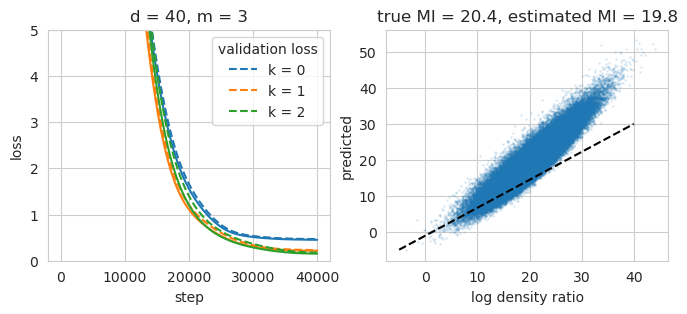

In [235]:
ldretrue_n = get_ldre(X_nx2d)
xmin = -5
xmax = 40
ymin = -5
ymax = 30
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(8, 3))

plt.subplot(121)
for i in range(m):
    plt.plot(dfs[i]['train_loss'], c=colors[i]);
    plt.plot(dfs[i]['val_loss'], '--', c=colors[i], label='k = {}'.format(i));
plt.legend(title='validation loss');
plt.xlabel('step');
plt.ylabel('loss');
plt.title('d = {}, m = {}'.format(d, m));
plt.ylim([0, 5]);

plt.subplot(122)
plt.scatter(ldretrue_n, np.sum(ldre_mxn, axis=0), alpha=0.1, s=1);
plt.plot([xmin, xmax], [ymin, ymax], '--k');
plt.xlabel('log density ratio');
plt.ylabel('predicted');
plt.title('true MI = {:.1f}, estimated MI = {:.1f}'.format(truemi, estmi));


# different means

In [15]:
def get_cov_2(d, sigma: float = 2):
    cov = np.eye(d)
    cov[0, 0] = sigma
    return cov

def get_data_diff_means(n, d, sigma: float = 2, mu: float = 1):
    Xm_nxd = sc.stats.multivariate_normal.rvs(
        mean=np.zeros([d]), cov=np.eye(d), size=n
    )
    mean = mu * np.ones([d])
    X0_nxd = sc.stats.multivariate_normal.rvs(
        mean=mean, cov=get_cov_2(d, sigma=sigma), size=n
    )
    return Xm_nxd, X0_nxd

def get_ldre_2(X_nxd, sigma: float = 2, mu: float = 1):
    d = X_nxd.shape[1]
    logd_n = sc.stats.multivariate_normal.logpdf(
        X_nxd, mean=np.zeros([d]), cov=np.eye(d))
    mean = mu * np.ones([d])
    logn_n = sc.stats.multivariate_normal.logpdf(
        X_nxd, mean=mean, cov=get_cov_2(d, sigma=sigma))
    return logn_n - logd_n

In [25]:
n = 100000
n_steps = 10000
ds = np.array([4, 8, 16, 32])
m = 1
lr = 5e-4
sigma = 1
mu = 1
device = torch.device('cpu')
singleratio_d = np.empty([ds.size])

for i, d in enumerate(ds):

    # get samples from p0 (target) and pm (source)
    Xm_nxd, X0_nxd = get_data_diff_means(n, d, sigma=sigma, mu=mu)

    # get waymark samples
    a_m1 = get_alphas(m)
    X_m1xnxd = get_waymark_samples(X0_nxd, Xm_nxd, a_m1)

    # fit bridges
    tldre = TelescopingLDRE(
        m, d, lr, n_steps, device=device, real_d=True, linear_component=True)
    dfs = tldre.fit(X_m1xnxd)

    Xm_nxd, _ = get_data_diff_means(n, d, sigma=sigma, mu=mu)
    _, ldre_mxn = tldre.estimate_mi(Xm_nxd)
    ldretrue_n = get_ldre_2(Xm_nxd, sigma=sigma, mu=mu)
    singleratio_d[i] = np.sqrt(
        np.mean(np.square(ldretrue_n - np.sum(ldre_mxn, axis=0))))
    print(d, singleratio_d[i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 142.32it/s]


Done fitting bridge 1 / 1 (70 sec)
4 0.022081706113172887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:10<00:00, 141.92it/s]


Done fitting bridge 1 / 1 (70 sec)
8 1.7114791378568743


  0%|                                                                                                                | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_79305/6069248.py:153: RuntimeWarning: overflow encountered in exp
  t =  1 / (1 + np.exp(-x))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:24<00:00, 118.72it/s]


Done fitting bridge 1 / 1 (84 sec)
16 4.604060530691856


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:11<00:00, 52.30it/s]


Done fitting bridge 1 / 1 (191 sec)
32 24.626605368843858


In [28]:
n = 100000
n_steps = 10000
ds = np.array([4, 8, 16, 32])
m = 3
lr = 1e-4
sigma = 1
mu = 1
device = torch.device('cpu')
tratio_d = np.empty([ds.size])

for i, d in enumerate(ds):

    # get samples from p0 (target) and pm (source)
    Xm_nxd, X0_nxd = get_data_diff_means(n, d, sigma=sigma, mu=mu)

    # get waymark samples
    a_m1 = get_alphas(m)
    X_m1xnxd = get_waymark_samples(X0_nxd, Xm_nxd, a_m1)

    # fit bridges
    tldre = TelescopingLDRE(
        m, d, lr, n_steps, device=device, real_d=True, linear_component=True)
    dfs = tldre.fit(X_m1xnxd)

    Xm_nxd, _ = get_data_diff_means(n, d, sigma=sigma, mu=mu)
    _, ldre_mxn = tldre.estimate_mi(Xm_nxd, sigma=sigma, mu=mu)
    
    ldretrue_n = get_ldre_2(Xm_nxd)
    tratio_d[i] = np.sqrt(
        np.mean(np.square(ldretrue_n - np.sum(ldre_mxn, axis=0))))
    print(d, tratio_d[i])

 24%|████████████████████████                                                                            | 2408/10000 [00:17<00:54, 140.26it/s]

KeyboardInterrupt



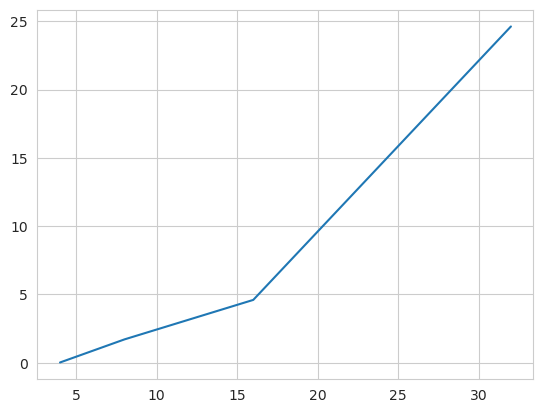

In [26]:
plt.plot(ds, singleratio_d);
# plt.plot(ds, tratio_d);

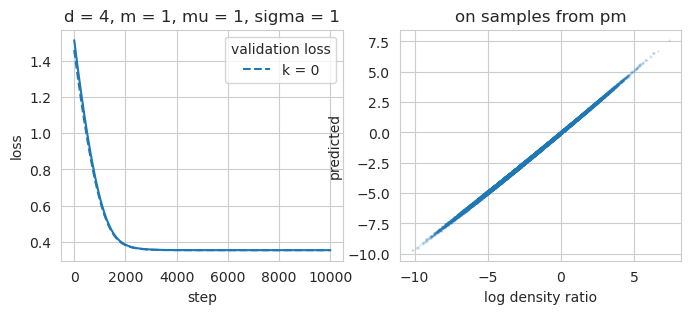

In [24]:
# ldretrue_n = get_ldre_2(Xm_nxd)
# xmin = -5
# xmax = 15
# ymin = -5
# ymax = 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(8, 3))

plt.subplot(121)
for i in range(m):
    plt.plot(dfs[i]['train_loss'], c=colors[i]);
    plt.plot(dfs[i]['val_loss'], '--', c=colors[i], label='k = {}'.format(i));
plt.legend(title='validation loss');
plt.xlabel('step');
plt.ylabel('loss');
plt.title('d = {}, m = {}, mu = {}, sigma = {}'.format(d, m, mu, sigma));
# plt.ylim([0, 5]);

plt.subplot(122)
plt.scatter(ldretrue_n, np.sum(ldre_mxn, axis=0), alpha=0.1, s=1);
# plt.plot([xmin, xmax], [ymin, ymax], '--k');
plt.xlabel('log density ratio');
plt.ylabel('predicted');
plt.title('on samples from pm');